# Basic Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose, GlobalMaxPooling2D, Activation, Multiply,\
Concatenate,Reshape,Input,concatenate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Convertinginto Dataframe

In [2]:
root='/kaggle/input/ewastenet-e-waste-image-classification-dataset/EWasteNet/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

In [3]:
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data

,path,class_
796,/kaggle/input/ewastenet-e-waste-image-classifi...,Keyboards
90,/kaggle/input/ewastenet-e-waste-image-classifi...,Mouses
472,/kaggle/input/ewastenet-e-waste-image-classifi...,smartwatch
448,/kaggle/input/ewastenet-e-waste-image-classifi...,laptop
414,/kaggle/input/ewastenet-e-waste-image-classifi...,laptop
...,...,...
14,/kaggle/input/ewastenet-e-waste-image-classifi...,Mouses
559,/kaggle/input/ewastenet-e-waste-image-classifi...,Movile
161,/kaggle/input/ewastenet-e-waste-image-classifi...,microwave
252,/kaggle/input/ewastenet-e-waste-image-classifi...,TV


In [4]:
data["class_"].value_counts()

Movile        152
TV            131
laptop        117
Keyboards     109
Mouses        104
microwave     102
smartwatch    100
camera         62
Name: class_, dtype: int64

# Data Splitting

In [5]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]
train,test=split_data(data,.8)
validation,train=split_data(train,.08)

In [6]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)
validation.to_csv('valid.csv',index=False)

In [7]:
train["class_"].value_counts()

Movile        144
TV            122
laptop        104
microwave      95
Keyboards      95
Mouses         94
smartwatch     93
camera         60
Name: class_, dtype: int64

In [8]:
validation['class_'].value_counts()

Keyboards     14
laptop        13
Mouses        10
TV             9
Movile         8
smartwatch     7
microwave      7
camera         2
Name: class_, dtype: int64

In [9]:
test['class_'].value_counts()

Movile        33
TV            31
Keyboards     22
laptop        21
microwave     20
Mouses        19
camera        16
smartwatch    14
Name: class_, dtype: int64

# Preprocessing 

In [10]:
size=384
batch_size=4
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

valid_generator = ImageDataGenerator(
    rescale=1.0 / 255,
)
valid_images = valid_generator.flow_from_dataframe(
    dataframe=validation,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset='training'
)

test_generator = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset='training'
)

Found 806 validated image filenames belonging to 8 classes.
Found 70 validated image filenames belonging to 8 classes.
Found 175 validated image filenames belonging to 8 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


# Importing DeiT from Tensorflow Hub

In [11]:
import tensorflow_hub as hub
def get_from_hub(model_url,size=384):
    inputs = tf.keras.Input((size, size, 3))
    hub_module = hub.KerasLayer(model_url,trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [12]:
deit_shovel=get_from_hub('https://tfhub.dev/sayakpaul/deit_base_patch16_384_fe/1')
deit_aspp=get_from_hub('https://tfhub.dev/sayakpaul/deit_base_patch16_384_fe/1')

# Shovel operator

In [13]:
import keras.backend as K
def sobel(shape, dtype=None):

    f = np.array([
            [[[-1],[-1],[-1]], [[0],[0],[0]], [[1],[1],[1]]],
            [[[-2],[-2],[-2]], [[0],[0],[0]], [[2],[2],[2]]],
            [[[-1],[-1],[-1]], [[0],[0],[0]], [[1],[1],[1]]]
        ])

    return K.variable(f, dtype='float32')

# Shovel Steam

In [14]:
steam1 = Sequential()
steam1.add(Conv2D(1, (3, 3),kernel_initializer=sobel, padding='same', input_shape=(size, size, 3), use_bias=False))
steam1.layers[0].trainable=False
steam1.add(Conv2D(3, (3, 3), padding='same'))

shovel_output=deit_shovel(steam1.output)

# CBAM for attention

In [15]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam_block(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

# ASPP block

In [16]:
def aspp_block(inputs,dilation_rates,features):
    outputs = []
    for i,dilation_rate in enumerate(dilation_rates):
        x = tf.keras.layers.Conv2D(filters= features[i] , kernel_size=3, strides=1, padding="same", dilation_rate=dilation_rate)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        outputs.append(x)
    x = tf.keras.layers.Concatenate(axis=-1)(outputs)
    return x

# ASPP-CBAM steam

In [17]:
steam2 = Sequential()
steam2.add(Input(shape=(size,size,3)))
aspp_output= aspp_block(steam2.output, [1,2,3,4,5],[64,32,16,8,4])
aspp_output=cbam_block(aspp_output)
aspp_output=Conv2D(3, (3, 3), padding='same')(aspp_output)

aspp_output=deit_aspp(aspp_output)

In [18]:
combined=concatenate([shovel_output[0],aspp_output[0]])
x = Dense(512,activation='relu')(combined)
x=Dropout(.3)(x)
x = Dense(256,activation='relu')(x)
x=Dropout(.2)(x)
x = Dense(256,activation='relu')(x)
output= Dense(len(train_images.class_indices), activation='softmax')(x)
model = Model([steam1.input,steam2.input], output)

In [19]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 997040 non trainable parametres: 172181267


In [20]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]


In [21]:
model.compile(loss="categorical_crossentropy",optimizer=tf.optimizers.Adam(),metrics=['accuracy'])

In [22]:
history = model.fit(
    generator_two_img(train_images),
    validation_data=generator_two_img(valid_images),
    validation_steps=valid_images.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_images.n//batch_size,
    batch_size=batch_size,
    epochs=20,
)

Epoch 1/20
201/201 [==============================] - 193s 722ms/step - loss: 0.9885 - accuracy: 0.6517 - val_loss: 0.2143 - val_accuracy: 0.9265
Epoch 2/20
201/201 [==============================] - 142s 705ms/step - loss: 0.4451 - accuracy: 0.8516 - val_loss: 0.1486 - val_accuracy: 0.9412
Epoch 3/20
201/201 [==============================] - 141s 704ms/step - loss: 0.2800 - accuracy: 0.9052 - val_loss: 0.1155 - val_accuracy: 0.9706
Epoch 4/20
201/201 [==============================] - 141s 703ms/step - loss: 0.2128 - accuracy: 0.9352 - val_loss: 0.1050 - val_accuracy: 0.9412
Epoch 5/20
201/201 [==============================] - 141s 701ms/step - loss: 0.2259 - accuracy: 0.9289 - val_loss: 0.0484 - val_accuracy: 0.9853
Epoch 6/20
201/201 [==============================] - 141s 704ms/step - loss: 0.2351 - accuracy: 0.9302 - val_loss: 0.0434 - val_accuracy: 0.9853
Epoch 7/20
201/201 [==============================] - 141s 702ms/step - loss: 0.2050 - accuracy: 0.9277 - val_loss: 0.0868 -

In [23]:
model.save('model.h5')

Text(0, 0.5, 'accuracy')

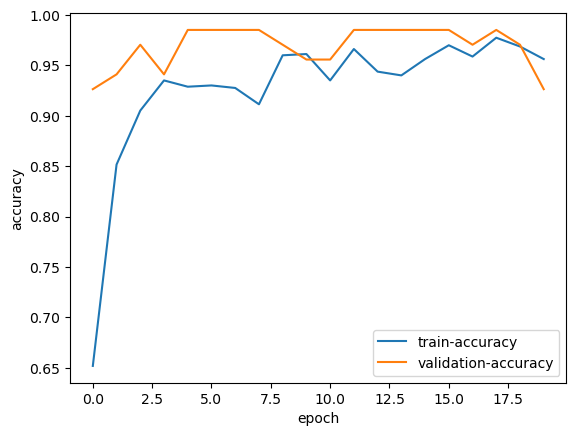

In [24]:
epochs = list(range(len(history.history['accuracy'])))
train_acc = history.history['accuracy']
train_loss = history.history['val_accuracy']
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train-accuracy','validation-accuracy'], loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.show()


Text(0, 0.5, 'loss')

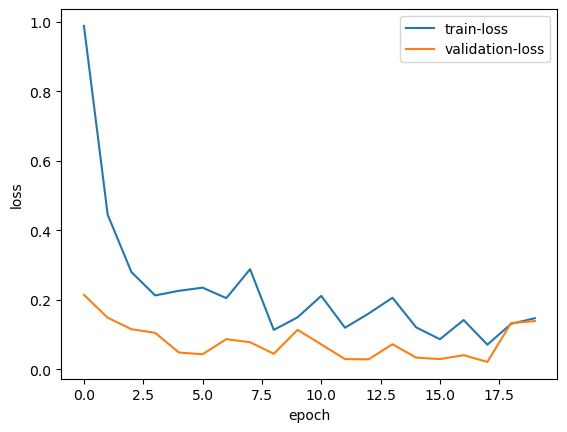

In [25]:
epochs = list(range(len(history.history['accuracy'])))
train_acc = history.history['loss']
train_loss = history.history['val_loss']
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train-loss','validation-loss'], loc='best')
# plt.show()
plt.xlabel('epoch')
plt.ylabel('loss')

In [26]:
class_=train_images.class_indices.keys()
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break

# Validation Results

In [27]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
proba=model.predict(prediction_generator(valid_images))
predicted = np.argmax(proba,axis=1)
true=valid_images.labels
print("acc: ", accuracy_score(predicted, true))
print("preci: ", precision_score(predicted, true,average='macro'))
print("recall: ", recall_score(predicted, true,average='macro'))
print("f1: ", f1_score(predicted, true,average='macro'))
print("mcc: ", matthews_corrcoef(predicted, true))

18/18 [==============================] - 9s 313ms/step
acc:  0.9285714285714286
preci:  0.9330929487179487
recall:  0.9330357142857143
f1:  0.9298611111111111
mcc:  0.9172849010543946


# Test Results

In [28]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
proba=model.predict(prediction_generator(test_images))
predicted = np.argmax(proba,axis=1)
true=test_images.labels
print("acc: ", accuracy_score(predicted, true))
print("preci: ", precision_score(predicted, true,average='macro'))
print("recall: ", recall_score(predicted, true,average='macro'))
print("f1: ", f1_score(predicted, true,average='macro'))
print("mcc: ", matthews_corrcoef(predicted, true))

44/44 [==============================] - 13s 288ms/step
acc:  0.96
preci:  0.9664772727272728
recall:  0.9670138888888888
f1:  0.9645769337856527
mcc:  0.9547568576660498


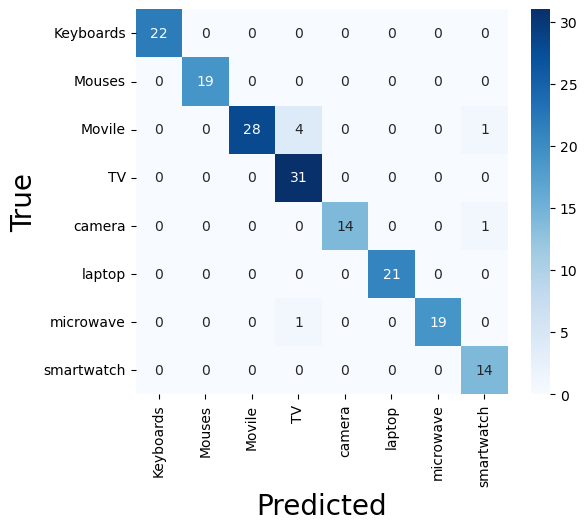

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)
fig = plt.figure(figsize=(6, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="Blues"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

/tmp/ipykernel_24/1366517963.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


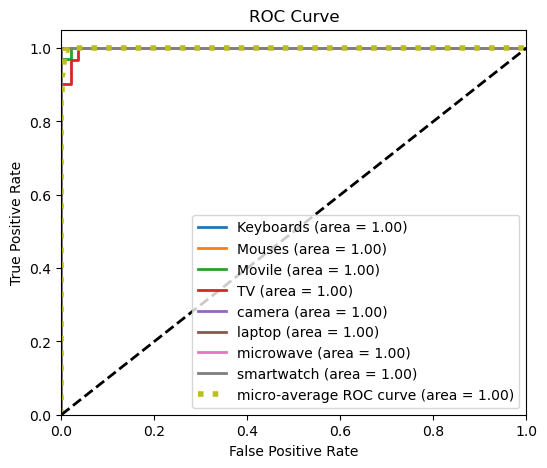

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm
n=len(true)
dim=max(true)+1
result=[]
for i in true:
    result.append([0 for i in range(dim)])
    result[len(result)-1][i]=1
    
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =len(test_images.class_indices.keys())
y_test=np.array(result)
y_pred=np.array(proba)
fpr = dict()
tpr = dict()
roc_auc = dict()

rev={}
for i in class_:
    rev[train_images.class_indices[i]]=i


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')


cmap = cm.get_cmap('tab10')

# Plot the ROC curve for each class and micro-average with automatic color selection
plt.figure(figsize=(6,5))
lw = 2
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(rev[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()